# The Interface functions and Solution Container

In this tutorial, we demonstrate the use of the dcegm package interface functions to visualize the a solved model and explain the structure of the solution container, which is the output of the `solve` functions.

The interface functions are designed to make it easier to use the dcegm package. The interface functions explained here are:
- `policy_for_state_choice_vec`: This function returns the policy function for a given state and choice, after solving the model.
- `get_state_choice_index_per_discrete_state_and_choice`: This function returns the index of a particular state and choice in the solution container.

The solve functions we will use are:
- `solve_dcegm`: This function creates and solves a model with a given set of parameters and options.
- `get_solve_func_for_model`: This function returns the solve function for a given model.




## Importing the necessary packages and functions

In [1]:
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

from dcegm.pre_processing.setup_model import setup_model
from dcegm.solve import (
    get_solve_func_for_model,
)

from dcegm.interface import (
    get_state_choice_index_per_discrete_state_and_choice,
)

from toy_models.load_example_model import load_example_models

# set the jax_enable_x64 configuration option
jax.config.update("jax_enable_x64", True)

## Setting up the model `params` and `options`

We will use the `params` and `options` dictionaries to set up the model. The `params` dictionary contains the parameters of the model, and the `options` dictionary contains the options for the solution process of a particular model. We also import the model functions from the toy models module. For this tutorial, we will use the simple life-cycle models of consumption with discrete retirement decisions from Iskhakov et al. (2017).

In [2]:
# model: retirement model without taste shocks and income uncertainty

params = {
    "beta": 0.98,  # discount factor
    "delta": 1.00,  # disutility of work
    "constant": np.log(20.0),  # age-independent labor income
    "rho": 1.00,  # coefficient of relative risk aversion
    "exp": 0.00,  # return to experience
    "exp_squared": 0.0,  # return to experience squared
    "sigma": 0.0,  # shock on labor income sigma parameter/standard deviation
    "lambda": 0.10,  # taste shock (scale) parameter
    "interest_rate": 0.00,  # interest rate on capital
    "consumption_floor": 0.5,  # consumption floor/retirement safety net (only relevant in the dc-egm retirement model)
}
model_params = {
    "n_periods": 44,  # number of periods
    "min_age": 20,  # minimum age
    "quadrature_points_stochastic": 15,  # number of quadrature points for stochastic integration
}
options = {
    "model_params": model_params,
    "state_space": {
        "n_periods": 44,  # number of periods T
        "choices": np.array([0, 1]),  # choices d
        "continuous_states": {  # continuous decision state
            "wealth": jnp.linspace(  # wealth grid e.g. equally spaced grid
                0,  # minimum wealth
                150,  # maximum wealth
                2000,  # min. number of grid points
            )
        },
    },
}


# load the model functions
model_funcs = load_example_models("dcegm_paper")

## Debugggging

Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  3
Model setup complete.

Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  3
Model setup complete.

Update function for state space not given. Assume states only change with an increas

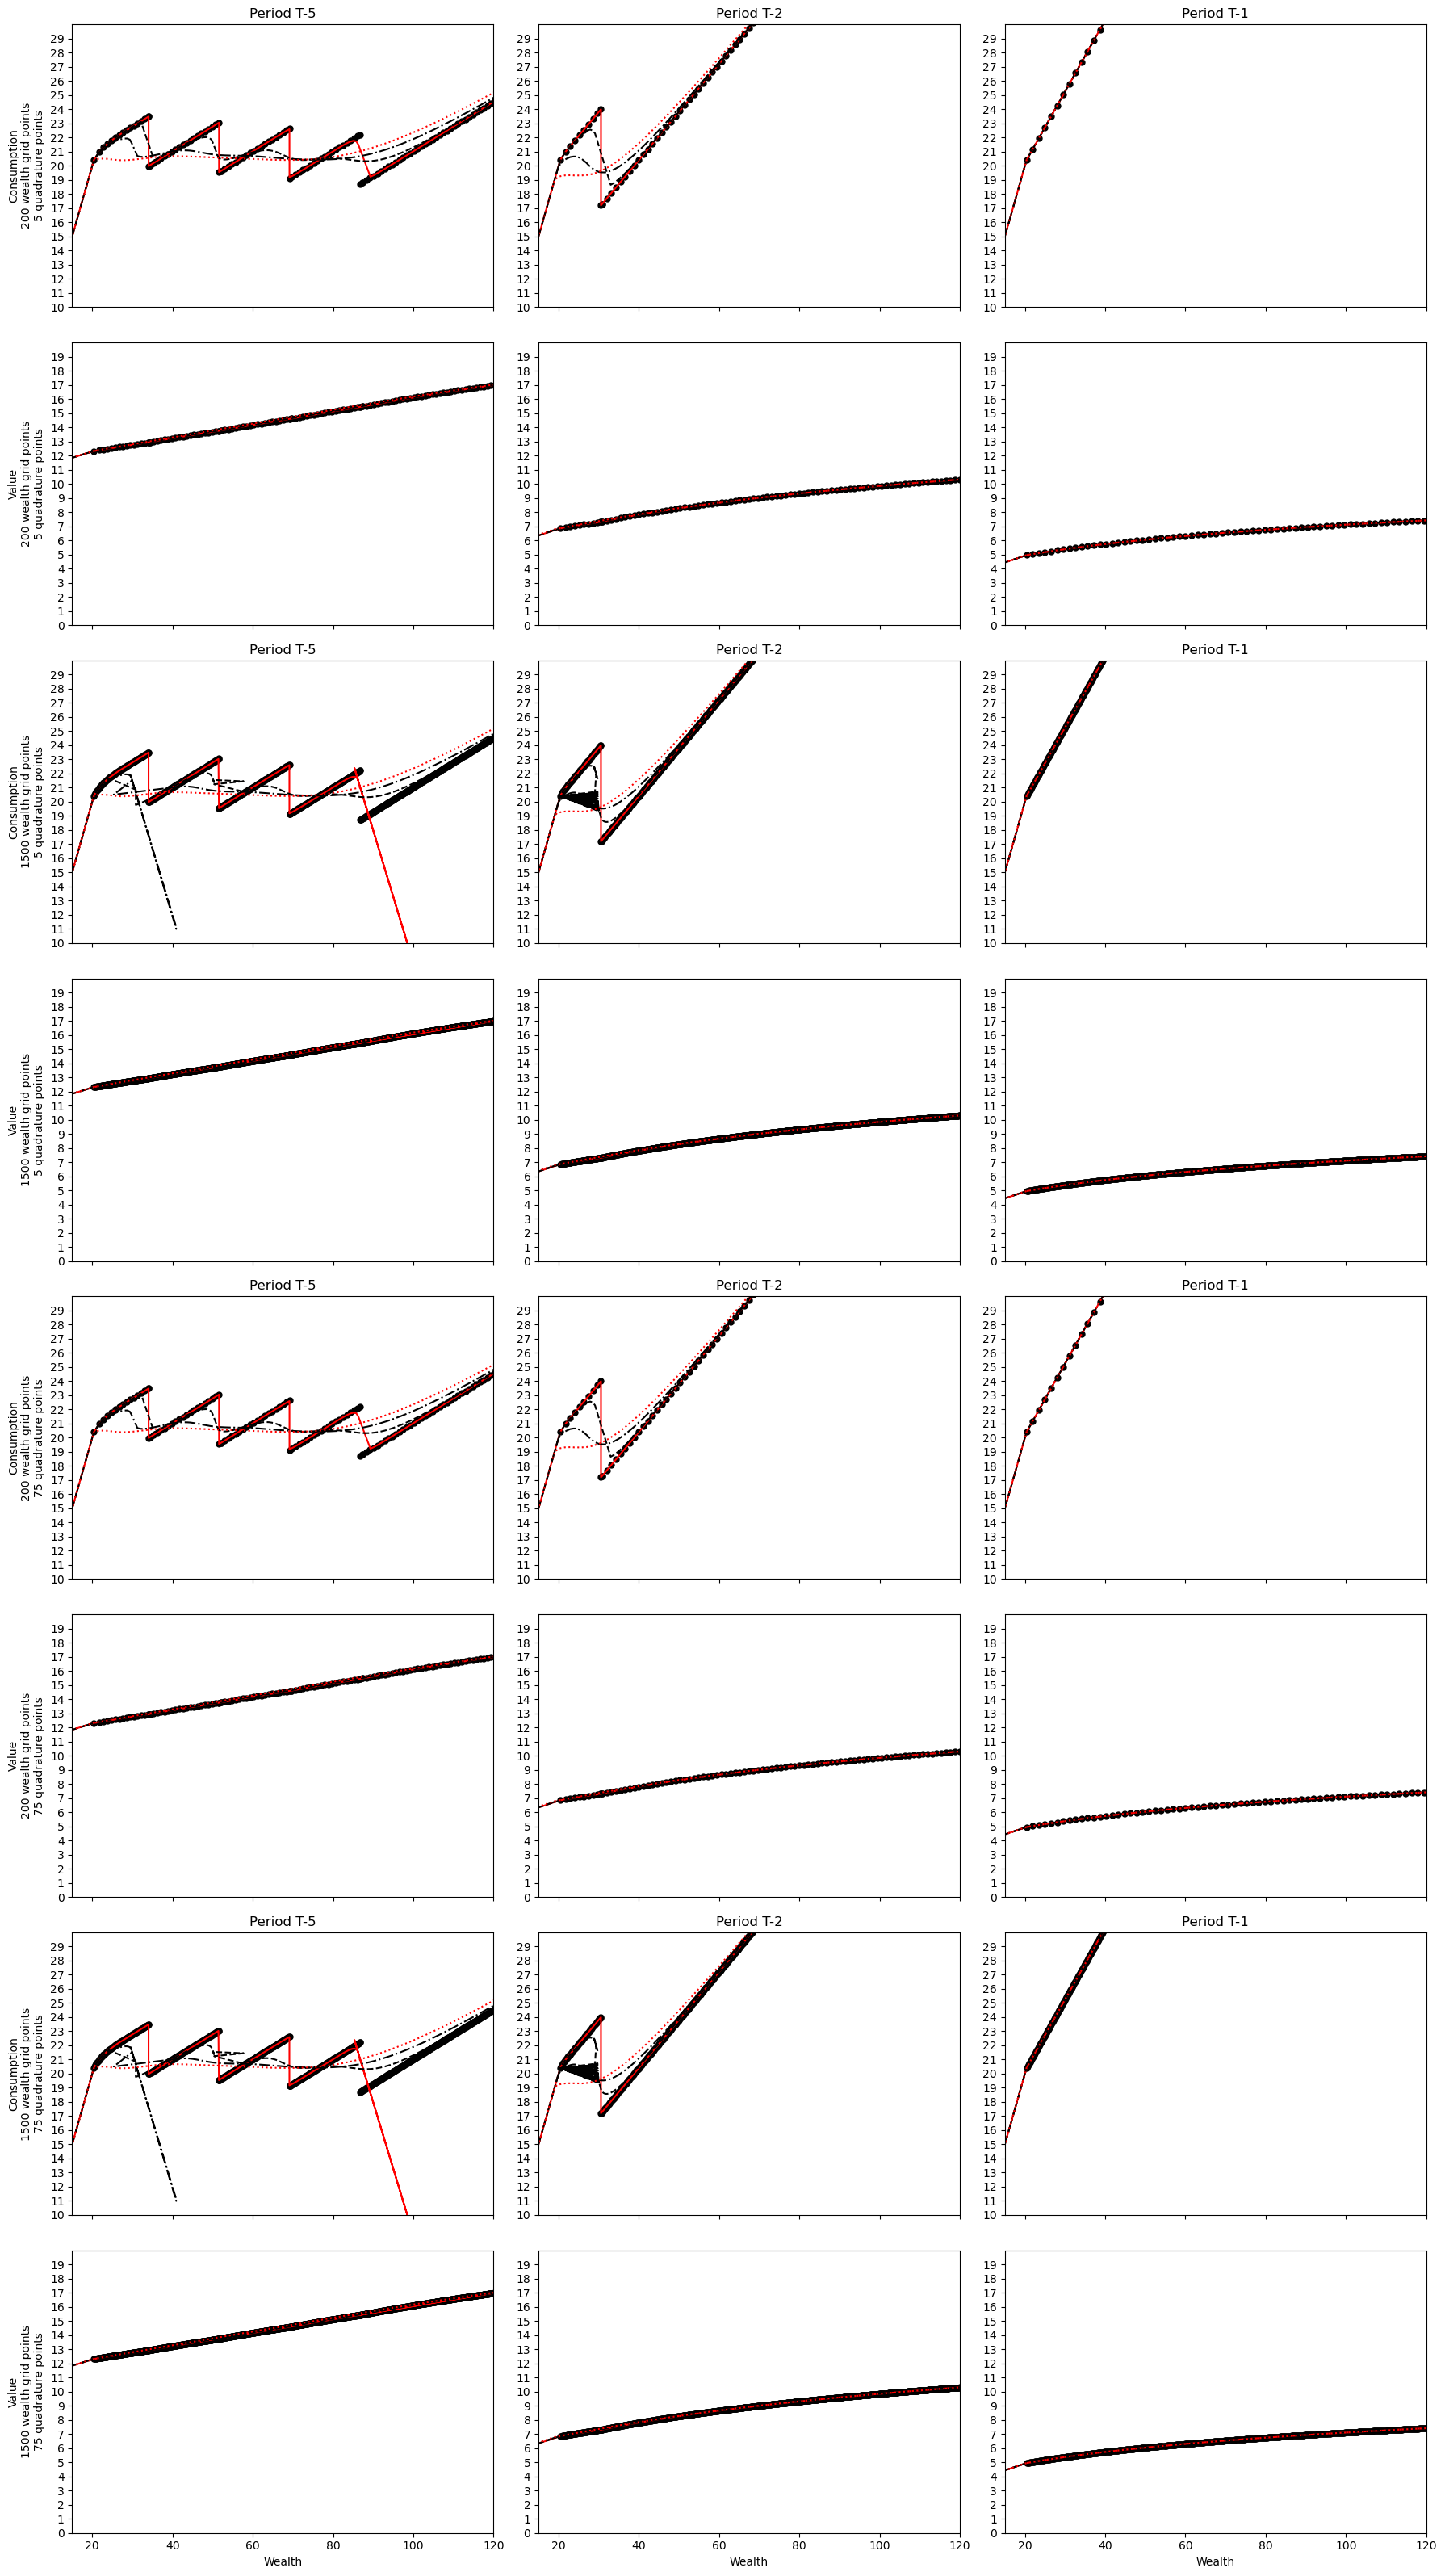

In [ ]:
line_styles = [
    {
        "color": "black",
        "marker": "o",
        "linestyle": "None",
        "markersize": 5,
    },  # Black dots
    {"color": "red", "linestyle": "-"},  # Red solid line
    {"color": "black", "linestyle": "--"},  # Black dashed line
    {"color": "black", "linestyle": "-."},  # Black dash-dot line
    {"color": "red", "linestyle": ":"},  # Red dotted line
]

quadrature_points_list = [5, 75]
wealth_grid_points_list = [200, 1500]
taste_shock_scales = [2e-16, 0.01, 0.05, 0.10, 0.15]
n_periods = options["model_params"]["n_periods"]
test_periods = [
    n_periods - 6,
    n_periods - 3,
    n_periods - 2,
]  # zero-based index so T-5, T-2, T-1

fig, axes = plt.subplots(
    len(quadrature_points_list) * len(wealth_grid_points_list) * 2,
    len(test_periods),
    figsize=(
        len(test_periods) * 6,
        len(quadrature_points_list) * len(wealth_grid_points_list) * 2 * 4,
    ),
    sharex=True,
)

axes = axes.reshape(
    len(quadrature_points_list), len(wealth_grid_points_list), 2, len(test_periods)
)

for i, n_quadrature_points in enumerate(quadrature_points_list):
    for j, n_wealth_grid_points in enumerate(wealth_grid_points_list):
        options["model_params"]["quadrature_points_stochastic"] = n_quadrature_points
        options["state_space"]["continuous_states"]["wealth"] = jnp.linspace(
            0, 150, n_wealth_grid_points
        )
        model = setup_model(
            options=options,
            state_space_functions=model_funcs["state_space_functions"],
            utility_functions=model_funcs["utility_functions"],
            utility_functions_final_period=model_funcs[
                "final_period_utility_functions"
            ],
            budget_constraint=model_funcs["budget_constraint"],
        )
        solve_func = get_solve_func_for_model(model)

        for t, test_period in enumerate(test_periods):
            for k, taste_shock_scale in enumerate(taste_shock_scales):
                params["lambda"] = taste_shock_scale
                state_choice_dict = {
                    "period": test_period,
                    "lagged_choice": 0,
                    "dummy_exog": 0,
                    "choice": 0,
                }
                value, policy, endog_grid = solve_func(params)
                state_choice_index = (
                    get_state_choice_index_per_discrete_state_and_choice(
                        model, state_choice_dict
                    )
                )
                wealth_grid = jnp.take(endog_grid, state_choice_index, axis=0)
                consumption = jnp.take(policy, state_choice_index, axis=0)
                value_function = jnp.take(value, state_choice_index, axis=0)

                # Consumption function subplot
                ax_c = axes[i, j, 0, t]
                ax_c.plot(
                    wealth_grid,
                    consumption,
                    label=f"λ={taste_shock_scale:.2f}",
                    **line_styles[k],
                )
                ax_c.set_xlim([15, 120])
                ax_c.set_yticks(np.arange(10, 30, 1))
                ax_c.set_ylim([10, 30])
                if k == 0:
                    ax_c.set_title(f"Period T-{n_periods - test_period - 1}")
                if t == 0:
                    ax_c.set_ylabel(
                        f"Consumption\n{n_wealth_grid_points} wealth grid points\n{n_quadrature_points} quadrature points"
                    )

                # Value function subplot
                ax_v = axes[i, j, 1, t]
                ax_v.plot(
                    wealth_grid,
                    value_function,
                    label=f"V(λ={taste_shock_scale:.2f})",
                    **line_styles[k],
                )
                ax_v.set_xlim([15, 120])
                ax_v.set_ylim([0, 20])
                ax_v.set_yticks(np.arange(0, 20, 1))
                if t == 0:
                    ax_v.set_ylabel(
                        f"Value\n{n_wealth_grid_points} wealth grid points\n{n_quadrature_points} quadrature points"
                    )

# Label the x-axis only on the bottom row
for t in range(len(test_periods)):
    axes[-1, -1, 1, t].set_xlabel("Wealth")

plt.tight_layout()
plt.show()

In [4]:
#  # Solution with interpolation
#     # Set wealth grid for plotting"""  """
#     wealth_grid = np.linspace(0, 150, 100)
#     # Compute consumption policy for the wealth grid
#     consumption = np.zeros_like(wealth_grid, dtype=float)
#     for var_id, wealth in enumerate(wealth_grid):
#         policy_interp = policy_for_state_choice_vec(
#             endog_grid_solved=endog_grid,
#             policy_solved=policy,
#             model=model,
#             state_choice_vec=state_choice_dict,
#             wealth=wealth,
#         )
#         consumption[var_id] = policy_interp